In [1]:
import os
import itertools
import random
from math import log, exp, sqrt

from IPython.display import clear_output

import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.colors import LinearSegmentedColormap
from cycler import cycler


import matplotlib.animation as animation

import numpy as np
from scipy import stats
from numpy.linalg import norm

import ars

from BayesW_utils import *
from distributions import *

In [1]:
import pandas as pd

The time-to-event data is generated following the formula for the log time of individual i:

$$ \log Y_i = \mu + x_i \beta + \frac{w_i}{\alpha} + \frac{K}{\alpha} $$

where $\mu$ is the intercept, $x_i$ are the markers of individual, $\beta$ are the effects, $w_i$ are the random errors, $\alpha$ is the shape parameter of the Weibull distribution (Y) ("variance") and K is the EuMasc constant.

We will fix the following parameters:
- $\mu$=10
- $\alpha$=0.5
- genetic variance $\sigma_G^2$=0.5 

and the rest of the data are drawn from a distribution

-  $w_i \sim Gumbell(0,1)$ (standard extreme value distribution)
- $\beta \sim N(0,1)$
- $x_i \sim N(0, \sigma_G)$

Then $x_i\beta = g_i \sim N(0, \sigma_G)$.

And $\log Y_i$ follows a Gumbell distribution with 

$$E(log(Y_i)|) = \mu + x_i\beta$$

$$ Var(log(Y_i)|\mu +x_i\beta) = \frac{\pi^2}{6\alpha^2} $$

In [2]:
mu_real = 3.9
alpha_real = 10
sigma_g_real = np.pi**2/(6*alpha_real**2)

Text(0, 0.5, 'PDF(x)')

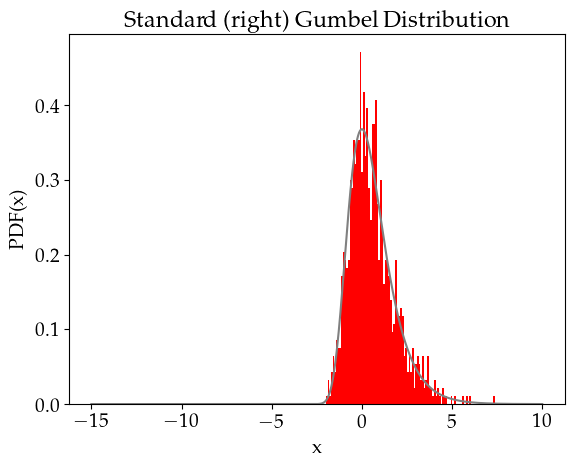

In [3]:
gumbel_dis = stats.gumbel_r(loc=0, scale=1)
# Generate data points
x = np.linspace(-15, 10, num=1000)

# Create Gumbel distribution object
gumbel_data = gumbel_dis.rvs(size=1000)

# Calculate PDF of Gumbel distribution for each data point
pdf = gumbel_dis.pdf(x)

# Plot the PDF of the Gumbel distribution
plt.hist(gumbel_data, density=True, bins=100)
plt.plot(x, pdf)
plt.title('Standard (right) Gumbel Distribution')
plt.xlabel('x')
plt.ylabel('PDF(x)')

In [4]:
n_markers = 200
n_samples = 100

In [5]:
w = gumbel_dis.rvs(size=(n_samples,1))
betas = np.random.normal(0, np.sqrt(sigma_g_real/n_markers), size = (n_markers, 1)) #simulate causal betas
markers = np.random.binomial(2,0.5,(n_samples, n_markers) )
norm_markers = helpers.normalize_markers(markers)

In [19]:
g = norm_markers.dot(betas)
np.mean(g), np.var(g), sigma_g_real

(-1.1032841307212494e-17, 0.020229230217882033, 0.016449340668482262)

''

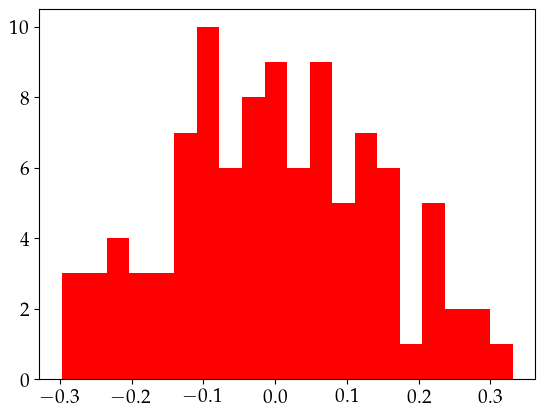

In [10]:
plt.hist(g, bins=20)
;

In [11]:
log_data = mu_real + g + w/alpha_real + np.euler_gamma/alpha_real

In [13]:
np.mean(log_data), np.var(log_data)

(4.021230006771348, 0.03414825995818869)

''

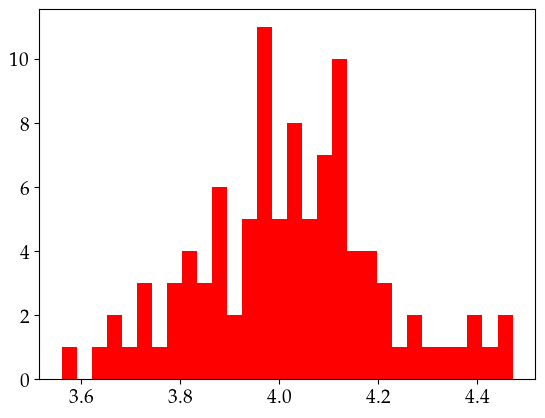

In [15]:
plt.hist(log_data, bins=30)
;

In [17]:
print("First sample: ", log_data[0][0])
print("Expected value: ", mu_real + g[0][0])

First sample:  4.095887001812885
Expected value:  3.694017953076687


In [18]:
print("Sample variance: ",np.var(log_data))
print("Phenotypic variance: ",sigma_g_real + np.pi**2/(6*alpha_real**2))

Sample variance:  0.03414825995818869
Phenotypic variance:  0.032898681336964525


In [20]:
prevalence = 1

In [21]:
d_array = np.random.choice([0,1], p=[1-prevalence, prevalence],size = n_samples)

Write the data to ped file

In [23]:
import pandas as pd

In [77]:

individual_id = index_list = ["ind" + str(i) for i in range(1, n_samples+1)]
family_id = individual_id
parental_id = np.zeros(n_samples,dtype='int')
maternal_id = np.zeros(n_samples,dtype='int')
sex = np.zeros(n_samples,dtype='int')
phenotype = log_data.reshape((100,))



In [78]:
df1 = pd.DataFrame({ "family_id": family_id, 
              "individual_id": individual_id, 
              "parental_id": parental_id, 
              "maternal_id": maternal_id, 
              "sex": sex, 
              "phenotype": phenotype})

In [79]:
markersdf = pd.DataFrame(markers)
di = {0: "AA", 1:"CA", 2: "CC"}
df = markersdf.replace(di)
for col in df.columns:
    # Split letters into two columns
    df[[str(col) + '_Letter1', str(col) + '_Letter2']] = df[col].str.split('', expand=True).iloc[:, 1:3]

    # Drop the original column
    df = df.drop(col, axis=1)

/tmp/ipykernel_14432/2079303480.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[[str(col) + '_Letter1', str(col) + '_Letter2']] = df[col].str.split('', expand=True).iloc[:, 1:3]
/tmp/ipykernel_14432/2079303480.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[[str(col) + '_Letter1', str(col) + '_Letter2']] = df[col].str.split('', expand=True).iloc[:, 1:3]
/tmp/ipykernel_14432/2079303480.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which ha

In [80]:
pd.concat([df1, df], axis=1).to_csv('sim1.ped', index=False, sep='\t', header=None)

MAP FILE

In [81]:
snp_id = ["snp" + str(i) for i in range(1, n_markers+1)]
chr_id = np.repeat("Chr1", n_markers)
distance = np.zeros(n_markers, dtype='int')
snp_pos = np.arange(1, n_markers+1)

In [82]:
df2 = pd.DataFrame({ "chr": chr_id, 
              "snp": snp_id, 
              "distance": distance, 
              "pos": snp_pos
              })

In [83]:
df2.to_csv("sim1.map", sep="\t", header=None, index=False)

In [86]:
df3 = pd.DataFrame({ "a": family_id, 
              "b": individual_id, 
              "c": phenotype
              })

In [88]:
df3.to_csv("Weibull.phen", sep="\t", header=None, index=None)

In [92]:
np.savetxt("Weibull.fail", d_array, fmt='%s')

In [20]:
pars = {"alpha": alpha_real,
        "sigma_g": sigma_g_real,
         

        "var_mu": 100, 
        "var_delta": 100,
        
        "alpha_zero": 0.01,
        "kappa_zero": 0.01,

        "d_array": d_array,
        "d": d_array.sum()/n_samples,

        "alpha_sigma": 1,
        "beta_sigma": 0.0001
}

In [21]:
epsilon = log_data 

In [22]:
f_mu = log_mu(pars, epsilon)
df_mu = dev_log_mu(pars, epsilon)

In [23]:
pars["d"]

1.0

In [24]:
-pars["alpha"]*pars["d"]*mu_real

-12.5

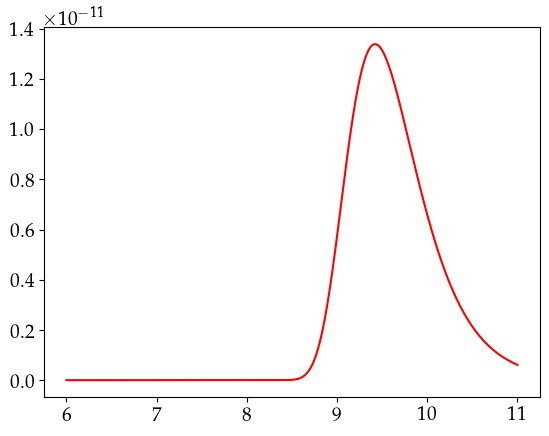

In [26]:
xplot = np.linspace(6,11,500)
p = [f_mu(x) for x in xplot]
plt.plot(xplot, np.exp(p))

In [38]:
pars["d"] = np.sum(d_array)

In [47]:
epsilon = log_data - g

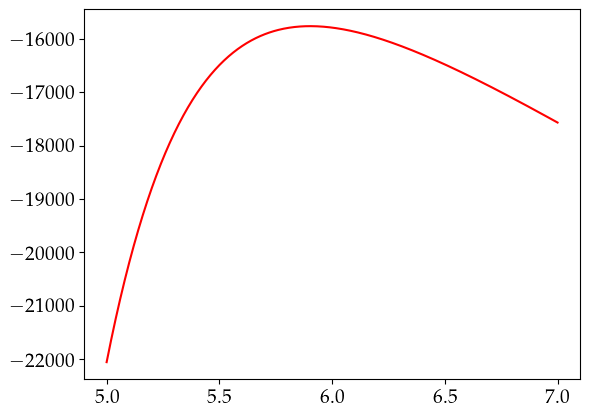

In [49]:
xplot = np.linspace(5,7,500)
p = [log_mu(pars, epsilon)(x) for x in xplot]
plt.plot(xplot, p)

In [55]:
markers[:,1]

array([1, 1, 1, 2, 1, 1, 1, 1, 2, 0, 1, 1, 1, 2, 1, 0, 1, 1, 1, 2, 2, 0,
       1, 2, 1, 1, 1, 1, 0, 2, 0, 2, 0, 2, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       2, 1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 2, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 2, 1, 0, 1, 1, 2, 0, 2, 2, 1, 0, 1, 1, 2, 1, 2, 1, 1,
       2, 1, 2, 2, 1, 1, 2, 2, 1, 2, 0, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2,
       2, 2, 0, 2, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 0, 2,
       0, 2, 0, 0, 1, 2, 1, 0, 1, 1, 0, 2, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 2, 2, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 2, 1, 2, 0, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2,
       2, 1, 1, 1, 0, 0, 2, 1, 1, 0, 0, 1, 0, 1, 1, 1, 2, 0, 2, 1, 2, 1,
       1, 1, 1, 0, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 2,
       2, 2, 1, 1, 0, 0, 2, 2, 1, 0, 1, 1, 2, 2, 0, 1, 1, 0, 2, 0, 2, 1,
       1, 1, 0, 1, 0, 2, 1, 2, 1, 1, 1, 2, 1, 0, 0, 1, 2, 0, 2, 1, 1, 2,
       1, 2, 2, 1, 2, 1, 0, 0, 2, 1, 2, 0, 2, 1, 1,

In [56]:
exp_epsilon = calculate_exp_epsilon(pars, epsilon)
compute_partial_sums(exp_epsilon, markers[:,1])

array([7.47466484e+08, 1.10819291e+09, 7.08847956e+08])

In [59]:
d_array * norm_markers[:,1]

array([ 0.01133713,  0.01133713,  0.01133713,  1.4284787 ,  0.01133713,
        0.01133713,  0.01133713,  0.01133713,  1.4284787 , -1.40580443,
        0.01133713,  0.01133713,  0.01133713,  1.4284787 ,  0.01133713,
       -1.40580443,  0.01133713,  0.01133713,  0.01133713,  1.4284787 ,
        1.4284787 , -1.40580443,  0.01133713,  1.4284787 ,  0.01133713,
        0.01133713,  0.01133713,  0.01133713, -1.40580443,  1.4284787 ,
       -1.40580443,  1.4284787 , -1.40580443,  1.4284787 , -1.40580443,
        0.01133713, -1.40580443, -1.40580443, -1.40580443,  0.01133713,
        0.01133713, -1.40580443, -1.40580443,  0.01133713,  1.4284787 ,
        0.01133713,  1.4284787 ,  1.4284787 ,  0.01133713, -1.40580443,
       -1.40580443,  0.01133713,  0.01133713,  0.01133713, -1.40580443,
        1.4284787 , -1.40580443,  0.01133713,  0.01133713,  0.01133713,
       -1.40580443, -1.40580443,  0.01133713, -1.40580443,  0.01133713,
        0.01133713, -1.40580443, -1.40580443,  0.01133713, -1.40

In [ ]:
pars["sum_fail"] = d_fail * marker[:,1]
pars["mean_sd_ratio"] = 
pars["mixture_C"] = 
pars[""]

In [ ]:
def log_mu(pars, epsilon_arr):
    '''computes the log-likelihood of the mu parameter'''
    return lambda x : (-pars['alpha']*x*pars['d'] - \
                       np.sum(np.exp((epsilon_arr - x)*pars['alpha'] -np.euler_gamma)) \
                        - (x**2)/(2*pars["var_mu"]))

In [49]:
-pars['alpha']*5*pars['d']

-12500.0

In [51]:
-np.sum(np.exp((log_data - 9)*pars['alpha'] -np.euler_gamma))

-2.3887462956856123

In [367]:
log_data.mean()

5.053878284589332

How can I define the probabilities of beta and x so that g follows a normal with variance sigma_G? We have to take into account that we are not simple multiplying two variables but also summing over the elements, so this changes everything...